<a href="https://colab.research.google.com/github/eyalhizmi/Machine-learning-methods-for-fMRI-signal-analysis/blob/main/final_project_fmri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nilearn 
# Download the standalone module if not using BrainIAK
from urllib.request import urlretrieve
urlretrieve('https://github.com/eyalhizmi/Machine-learning-methods-for-fMRI-signal-analysis/'
            'raw/main/tutorials/isc_standalone.py', 'isc_standalone.py');

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 16.7 MB/s 


In [2]:
from isc_standalone import (isc, isfc,
                            compute_summary_statistic, load_images,squareform_isfc,
                            load_boolean_mask, mask_images,
                            MaskedMultiSubjectData) 
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

import seaborn as sns
from scipy.stats import norm, pearsonr, zscore
from scipy.spatial.distance import squareform
import nibabel as nib

In [3]:
!wget -O movies_4rest_fmri_7T.mat https://www.dropbox.com/sh/4t21s5e2hz21r51/AABqx_CFpSOJJ76Np7oypCw2a/4movies_4rest_fmri_7T.mat?dl=0
!wget -O net_assignment.mat https://www.dropbox.com/sh/4t21s5e2hz21r51/AABCVCIKVxzl-hLgNQ1bwkUya/net_assignment.mat?dl=0

--2022-11-11 13:50:18--  https://www.dropbox.com/sh/4t21s5e2hz21r51/AABqx_CFpSOJJ76Np7oypCw2a/4movies_4rest_fmri_7T.mat?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/4t21s5e2hz21r51/AABqx_CFpSOJJ76Np7oypCw2a/4movies_4rest_fmri_7T.mat [following]
--2022-11-11 13:50:19--  https://www.dropbox.com/sh/raw/4t21s5e2hz21r51/AABqx_CFpSOJJ76Np7oypCw2a/4movies_4rest_fmri_7T.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc39e15f9aeed5b413947ad42ce3.dl.dropboxusercontent.com/cd/0/inline/BwhZ8bS7A6KTofp7YFG1533fWM2ZAtooAaNGdB1Uir0KtxrSV2hzFZQgqzdibpCPgVsaiQxVfg6uZ28sdtAJJF77_wzxGSeBCEv73PlaoAXldbo5s5ur2LiKlm6YFOqZ1LOVBPnJxn04CG1PF7QEcQ2ki-HCTvn8OzOHmfRS0SWXIQ/file# [following]
--2022-11-11 13:50:19--  https://uc39e15f9aeed5b413947a

## Exploration Data

In [108]:
data_ = loadmat('movies_4rest_fmri_7T.mat')
data = data_['splitData']


network_ = loadmat('net_assignment.mat')
network = network_['net_assignment']

In [109]:
movie_1 = data[0,1]
movie_1.shape

(181, 718, 227)

In [115]:
network_type = network==8
network_type = network_type.squeeze().astype(bool)
roi = movie_1[:,network_type,:]
roi = roi.transpose(0,2,1)
print(roi.shape)
roi_num = roi.shape[2]
iscs = isc(roi[1,:], pairwise=False)
iscs.shape


(181, 227, 46)


(46, 1)

In [105]:

iscs = isc(roi[1,:], pairwise=False)
iscs.shape



(46, 1)

In [7]:
data = [roi[subj,:] for subj in range(len(roi))]

subject_num = len(data)

iscs = isc(data, pairwise=True)
iscs.shape

# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"pairs and {iscs.shape[1]} voxels"
      f"\nMinimum ISC = {np.amin(iscs):.3f}; "
      f"maximum ISC = {np.amax(iscs):.3f}")



ISC values shape = (16290, 46) 
i.e., 16290 pairs and 46 voxels
Minimum ISC = -0.440; maximum ISC = 0.894


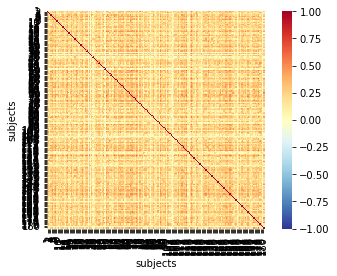

In [8]:
isc_matrix = squareform(iscs[:,2])
np.fill_diagonal(isc_matrix, 1)
sns.heatmap(isc_matrix, cmap="RdYlBu_r", vmin=-1, vmax=1, square=True, 
            xticklabels=range(1, subject_num), yticklabels=range(1, subject_num))
plt.xlabel('subjects')
plt.ylabel('subjects')
plt.show()

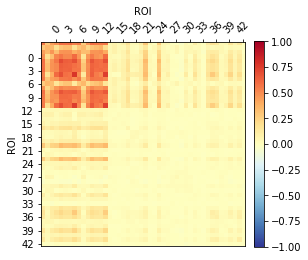

In [9]:
# Recompute mean ISFCs
isfcs, iscs = isfc(data, pairwise=False, summary_statistic='mean',
                   vectorize_isfcs=True)

# Convert these to a square representation
isfcs = squareform_isfc(isfcs, iscs)

# Visual mean ISFC matrix
plt.matshow(isfcs, cmap="RdYlBu_r", vmin=-1, vmax=1)
plt.grid(False)
plt.xticks(np.arange(0, roi_num, 3)[1:], np.arange(0, roi_num, 3),
           rotation=45)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.yticks(np.arange(0, roi_num, 3)[1:], np.arange(0, roi_num, 3))
plt.xlabel('ROI')
plt.ylabel('ROI')
ax = plt.gca()
plt.colorbar(fraction=0.046, pad=0.04);

## Classify Movies Task Base Network

In [98]:
data_ = loadmat('movies_4rest_fmri_7T.mat')
all_data = data_['splitData']


network_ = loadmat('net_assignment.mat')
network = network_['net_assignment'] 

In [ ]:
movies = all_data[0,1:5]

network_type = network==1
network_type = network_type.squeeze().astype(bool)

for movie in movies: 
  roi = movie[:,network_type,:]
  roi = roi.transpose(0,2,1)
  roi_num = roi.shape[2]
  data = [roi[subj,:] for subj in range(len(roi))]
  subject_num = len(data)

  iscs = isc(data, pairwise=True)
  iscs.shape

### FC

In [156]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')

movies = all_data[0,1:5]

network_type = network==8
network_type = network_type.squeeze().astype(bool)

correlation_per_movie = []
correlation_mean = []
for movie in movies:
  roi = movie[:,network_type,:]
  roi = roi.transpose(0,2,1)
  roi_num = roi.shape[2]
  data2cala = [roi[subj,:] for subj in range(len(roi))]

  correlation_matrices=correlation_measure.fit_transform(data2cala)

  correlation_mean.append(correlation_measure.mean_)
  correlation_per_movie.append(correlation_matrices)

print('Correlations of subject are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))


  

Correlations of subject are stacked in an array of shape (181, 46, 46)


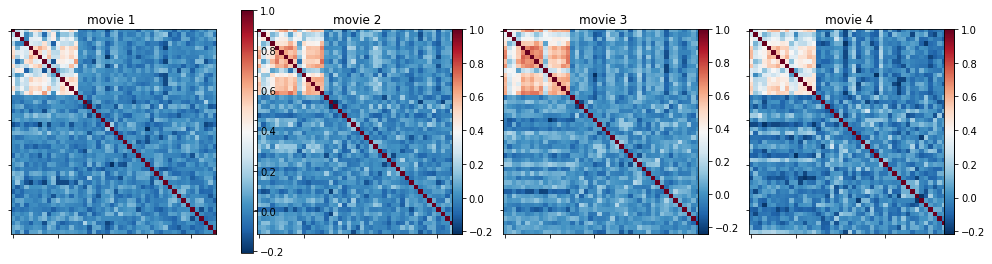

In [157]:
from nilearn import plotting
from matplotlib import pyplot as plt

subject_num = 1

_, axes = plt.subplots(1, 4, figsize=(20, 10))
for i, (matrix, ax) in enumerate(zip(correlation_per_movie, axes)):
    plotting.plot_matrix(matrix[subject_num,:], axes=ax) # tri = 'lower'
    ax.set_title(f'movie {i+1} ')

### classification

In [200]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True)

movies = all_data[0,1:5]

network_type = network==4
network_type = network_type.squeeze().astype(bool)

correlation_matrices  = []
label = []
for i , movie in enumerate (movies):
  roi = movie[:,network_type,:]
  roi = roi.transpose(0,2,1)
  subjects , TR , ROI = roi.shape
  data2cala = [roi[subj,:] for subj in range(len(roi))]

  correlation_vector =correlation_measure.fit_transform(data2cala) 
  correlation_matrices.append(correlation_vector)
  label.append(np.ones((subjects,), dtype=int)*(i+1))

correlation = np.concatenate(correlation_matrices)
label = np.concatenate(label)

print(correlation.shape)
print(label.shape)



(724, 4560)
(724,)


In [201]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(correlation, label, test_size = 0.1, random_state = 0) 

print(f'X Train : {X_train.shape}')
print(f'Y Train : {y_train.shape}')
print(f'X Test : {X_test.shape}')
print(f'Y test : {y_test.shape}')

X Train : (651, 4560)
Y Train : (651,)
X Test : (73, 4560)
Y test : (73,)


In [202]:
from sklearn.svm import SVC
model_svm = SVC(random_state = 0, kernel='linear', C=1)
model_svm.fit(X_train, y_train)


SVC(C=1, kernel='linear', random_state=0)

In [203]:
from sklearn.metrics import classification_report
y_train_pred = model_svm.predict(X_train)
print(classification_report(y_train, y_train_pred))

y_test_pred = model_svm.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       168
           2       1.00      1.00      1.00       162
           3       1.00      1.00      1.00       162
           4       1.00      1.00      1.00       159

    accuracy                           1.00       651
   macro avg       1.00      1.00      1.00       651
weighted avg       1.00      1.00      1.00       651

              precision    recall  f1-score   support

           1       0.92      0.92      0.92        13
           2       0.56      0.53      0.54        19
           3       0.57      0.68      0.62        19
           4       1.00      0.86      0.93        22

    accuracy                           0.74        73
   macro avg       0.76      0.75      0.75        73
weighted avg       0.76      0.74      0.75        73



### ISC

In [ ]:
movies = all_data[0,1:5]

network_type = network==1
network_type = network_type.squeeze().astype(bool)


fc_matrix = []
for movie in movies: 
  roi = movie[:,network_type,:]
  roi = roi.transpose(0,2,1)
  roi_num = roi.shape[2]
  data = [roi[subj,:] for subj in range(len(roi))]
  isfcs, iscs = isfc(data, pairwise=False, summary_statistic='mean',
                  vectorize_isfcs=True)
  fc_matrix.append(squareform_isfc(isfcs, iscs))

fig , axes  =plt.subplots(1,4 , figsize=(20,15))

for i, (fc, ax) in enumerate(zip(fc_matrix , axes)): 
  ax.matshow(fc, cmap="RdYlBu_r", vmin=-1, vmax=1)
  ax.xaxis.tick_bottom()
  ax.grid(False)
  ax.set_title(f'Movie {i}')
  ax.set_xlabel('ROI')
  ax.set_ylabel('ROI')

### ISFC

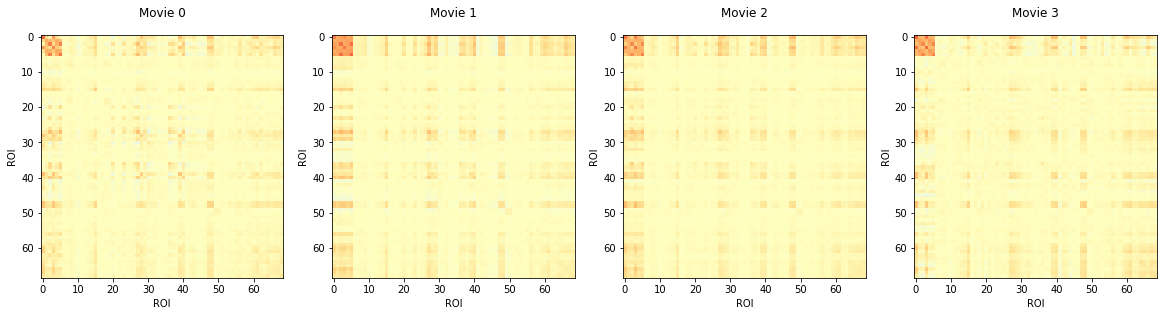

In [100]:
# combine 4 movies to the four diminsion 

movies = all_data[0,1:5]

network_type = network==1
network_type = network_type.squeeze().astype(bool)


fc_matrix = []
for movie in movies: 
  roi = movie[:,network_type,:]
  roi = roi.transpose(0,2,1)
  roi_num = roi.shape[2]
  data = [roi[subj,:] for subj in range(len(roi))]
  isfcs, iscs = isfc(data, pairwise=False, summary_statistic='mean',
                  vectorize_isfcs=True)
  fc_matrix.append(squareform_isfc(isfcs, iscs))

fig , axes  =plt.subplots(1,4 , figsize=(20,15))

for i, (fc, ax) in enumerate(zip(fc_matrix , axes)): 
  ax.matshow(fc, cmap="RdYlBu_r", vmin=-1, vmax=1)
  ax.xaxis.tick_bottom()
  ax.grid(False)
  ax.set_title(f'Movie {i}')
  ax.set_xlabel('ROI')
  ax.set_ylabel('ROI')
